In [189]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import matplotlib as mpl

linewidth_default = 2.0
fig_text_default = 15.
fig_title_default = fig_text_default*1.5

plt.rc('lines', linewidth=linewidth_default)    
plt.rc('text', usetex=False)
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100

In [2]:
ds = pd.read_csv('SIO_TEMP.csv',skiprows=29,encoding= 'unicode_escape',names=['YEAR','MONTH','DAY','TIME_PST',\
                                                                              'TIME_FLAG','SURF_TEMP_C','SURF_FLAG'\
                                                                              ,'BOT_TEMP_C','BOT_FLAG','empty1','empty2',\
                                                                              'empty3','empty4','empty5'])


In [154]:
# get SST array
mask = (ds['YEAR']>=2015) & (ds['YEAR']<=2020)
sst_raw = ds['SURF_TEMP_C'][mask]
# Fill in NaN's...
sst_corr = sst_raw.copy()
mask = np.isnan(sst_raw)
sst_corr[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), sst[~mask])

# create time array
print('date_start:', yr[0],mnth[0],day[0])
print('date_end:', yr[-1],mnth[-1],day[-1])
time = pd.date_range(start="2015-01-01",end="2020-12-31")

date_start: 2015 1 1
date_end: 2020 12 31


In [155]:
count_R=0
count_C=0
for i in np.arange(0,len(yr)):
    if np.isnan(np.array(sst_raw)[i]):
        count_R+=1
    if np.isnan(np.array(sst_corr)[i]):
        count_C+=1
print('raw dataset nan count:', count_R)
print('corrected dataset nan count:', count_C)

raw dataset nan count: 259
corrected dataset nan count: 0


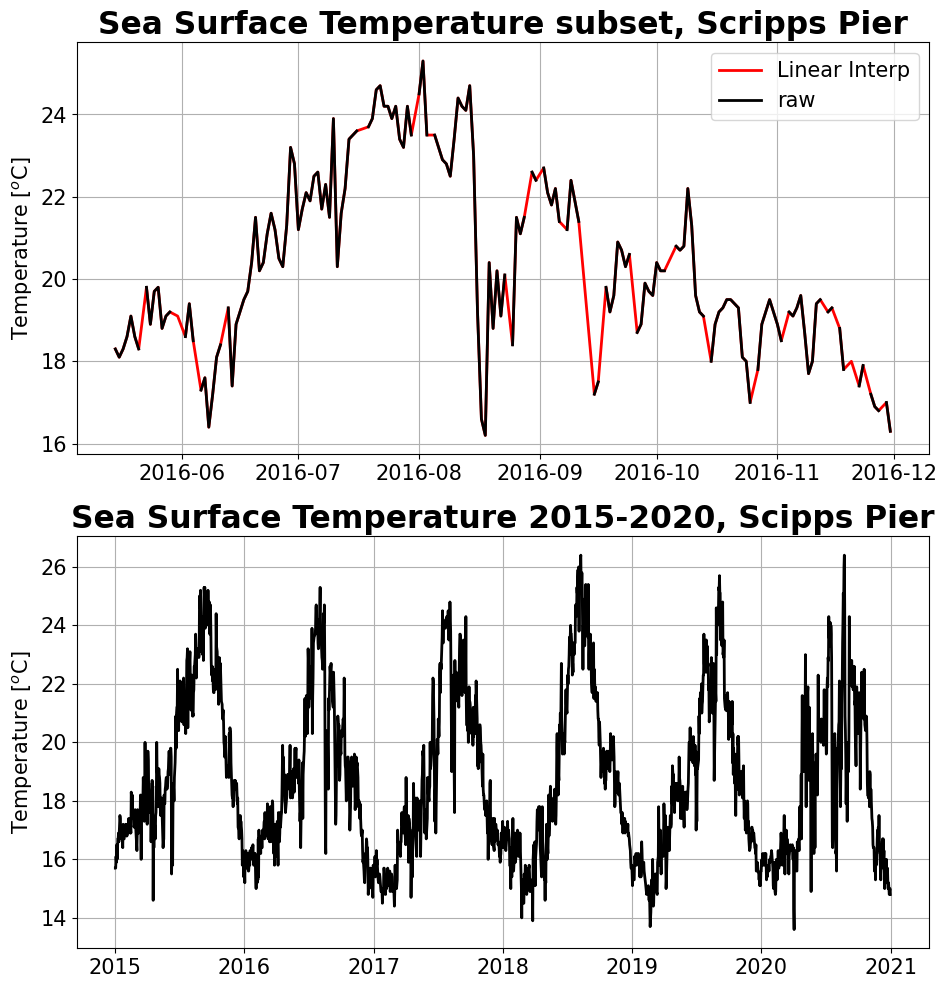

In [196]:
fig = plt.figure(figsize=(11,12))
ax1 = fig.add_subplot(2,1,1)
plt.plot(time[500:700],sst_corr[500:700],label='Linear Interp',color='r')
plt.plot(time[500:700],sst_raw[500:700],label='raw',color='k')
# plt.plot(time[500:700],sst_corr[500:700])
plt.title('Sea Surface Temperature subset, Scripps Pier')
plt.grid();plt.ylabel(r'Temperature [$^o$C]')
plt.legend()
ax2 = fig.add_subplot(2,1,2)
plt.plot(time,sst_corr,color='k')
plt.grid();plt.ylabel(r'Temperature [$^o$C]')
plt.title('Sea Surface Temperature 2015-2020, Scipps Pier')
plt.savefig('/Users/tyler/Desktop/SP22/ATS_655/HW5/figs/1ab.png',dpi=400,bbox_inches='tight')